**Chapter 3 - Classification**

# Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)


In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")


In [3]:
import matplotlib.pyplot as plt

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)


In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# MNIST

In [5]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)


In [6]:
print(mnist.DESCR)


**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [7]:
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [8]:
X, y = mnist.data, mnist.target
X


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [9]:
X.shape


(70000, 784)

In [10]:
y


array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [11]:
y.shape


(70000,)

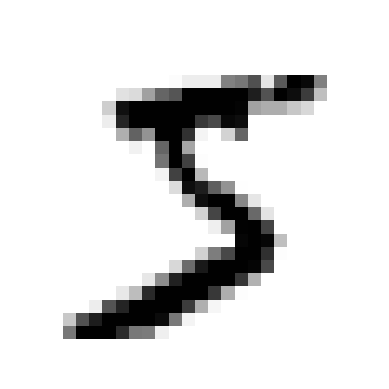

In [12]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")


some_digit = X[0]
plot_digit(some_digit)
plt.show()


In [13]:
y[0]


'5'

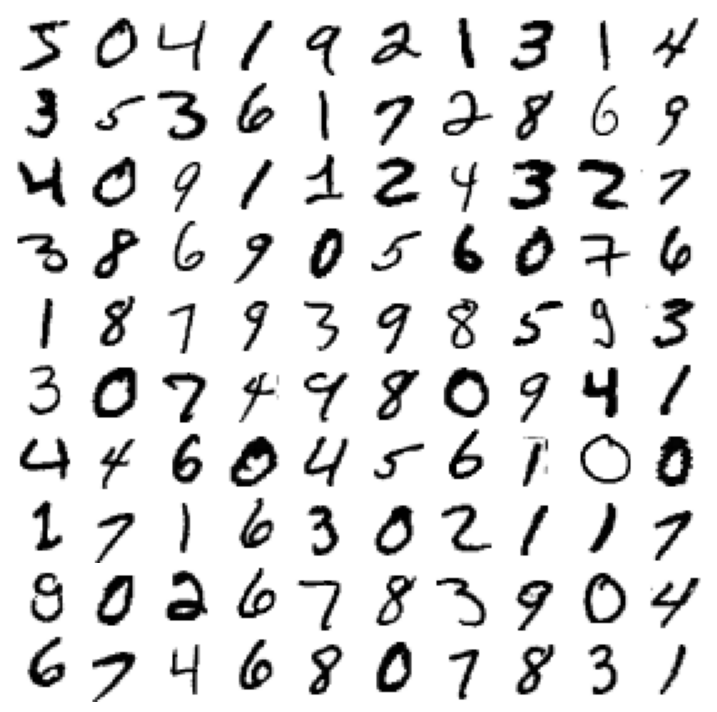

In [14]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)

plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()


In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


# Training a Binary Classifier

In [16]:
y_train_5 = y_train == "5"  # True para todos os 5, False para outros algarismos
y_test_5 = y_test == "5"


In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [18]:
sgd_clf.predict([some_digit])


array([ True])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [20]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))


False


In [21]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.90965, 0.90965, 0.90965])

In [22]:
# Implementando a Validação Cruzada
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(
    n_splits=3
)  # adicionar shuffle=True se o conjunto de dados ainda não foi embaralhado

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.95035
0.96035
0.9604


## Confusion Matrix

In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm


array([[53892,   687],
       [ 1891,  3530]])

In [25]:
y_train_perfect_predictions = y_train_5  # fingir que alcançamos a perfeição
confusion_matrix(y_train_5, y_train_perfect_predictions)


array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

In [26]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530/(687 + 3530)


0.8370879772350012

In [27]:
recall_score(y_train_5, y_train_pred)  # == 3530/(1891 + 3530)


0.6511713705958311

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)


0.7325171197343847

## Precicion/Recall Trade-off

In [29]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores


array([2164.22030239])

In [30]:
threshold = 0
y_some_digit_pred = y_scores > threshold


In [31]:
y_some_digit_pred


array([ True])

In [32]:
threshold = 3000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred


array([False])

In [33]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method="decision_function"
)


In [34]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


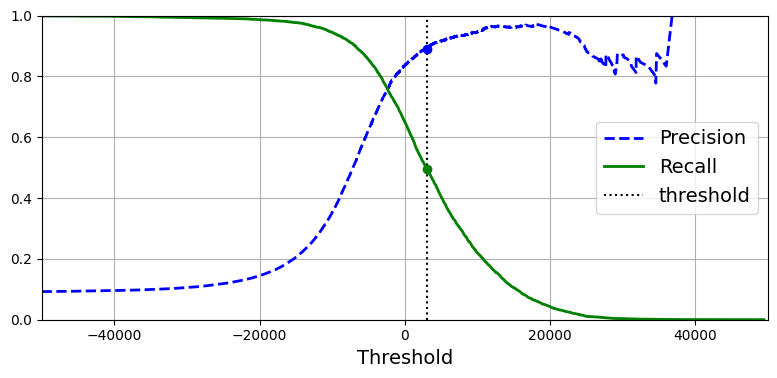

In [35]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()  # primeiro índice >= threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()


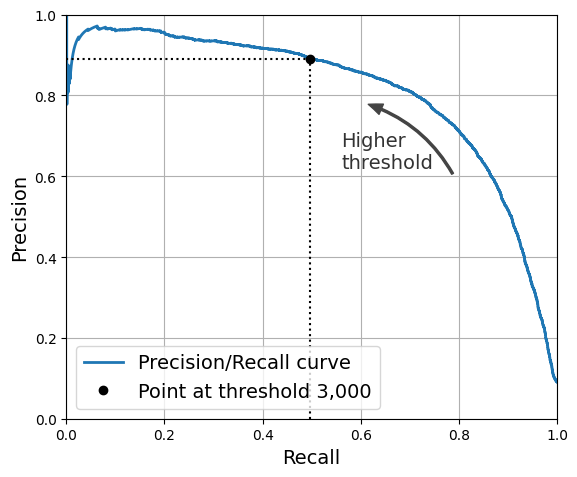

In [36]:
import matplotlib.patches as patches

plt.figure(figsize=(6, 5))

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0.0, precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot(
    [recalls[idx]], [precisions[idx]], "ko", label="Point at threshold 3,000"
)
plt.gca().add_patch(
    patches.FancyArrowPatch(
        (0.79, 0.60),
        (0.61, 0.78),
        connectionstyle="arc3,rad=.2",
        arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
        color="#444444",
    )
)
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()


In [37]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision


np.float64(3370.0194991439557)

In [38]:
y_train_pred_90 = y_scores >= threshold_for_90_precision


In [39]:
precision_score(y_train_5, y_train_pred_90)


0.9000345901072293

In [40]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision


0.4799852425751706

## The ROC Curve

In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


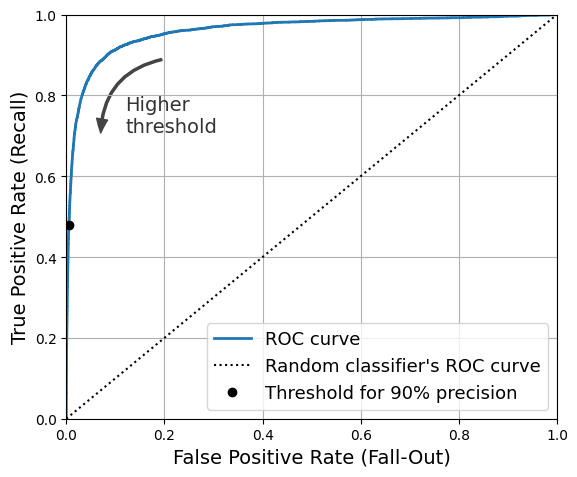

In [42]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], "k:", label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(
    patches.FancyArrowPatch(
        (0.20, 0.89),
        (0.07, 0.70),
        connectionstyle="arc3,rad=.4",
        arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
        color="#444444",
    )
)
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()


In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)


0.9604938554008616

In [44]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)


In [45]:
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method="predict_proba"
)


In [46]:
y_probas_forest[:2]


array([[0.11, 0.89],
       [0.99, 0.01]])

In [47]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest
)


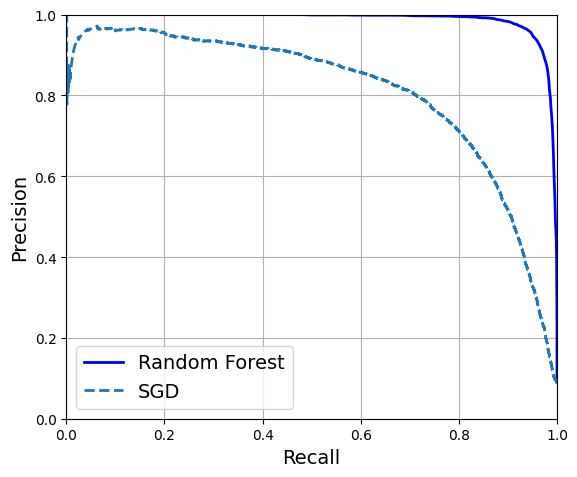

In [48]:
plt.figure(figsize=(6, 5))

plt.plot(
    recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest"
)
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()


In [49]:
y_train_pred_forest = (
    y_probas_forest[:, 1] >= 0.50
)  # probabilidade positiva >= 50%
f1_score(y_train_5, y_train_pred_forest)


0.9274509803921569

In [50]:
roc_auc_score(y_train_5, y_scores_forest)


0.9983436731328145

In [51]:
precision_score(y_train_5, y_train_pred_forest)


0.9897468089558485

In [52]:
recall_score(y_train_5, y_train_pred_forest)


0.8725327430363402

# Multiclass Classification

In [53]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [54]:
svm_clf.predict([some_digit])


array(['5'], dtype=object)

In [55]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)


array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [56]:
class_id = some_digit_scores.argmax()
class_id


np.int64(5)

In [57]:
svm_clf.classes_


array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [58]:
svm_clf.classes_[class_id]


'5'

In [59]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])


,estimator,SVC(random_state=42)
,n_jobs,None
,verbose,0
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001


In [60]:
ovr_clf.predict([some_digit])


array(['5'], dtype='<U1')

In [61]:
len(ovr_clf.estimators_)


10

In [62]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])


array(['3'], dtype='<U1')

In [63]:
sgd_clf.decision_function([some_digit]).round()


array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [64]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")


array([0.87365, 0.85835, 0.8689 ])

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([0.8983, 0.891 , 0.9018])

# Error Analysis

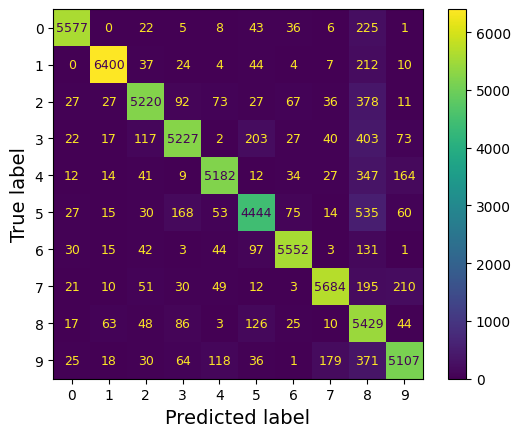

In [66]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc("font", size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()


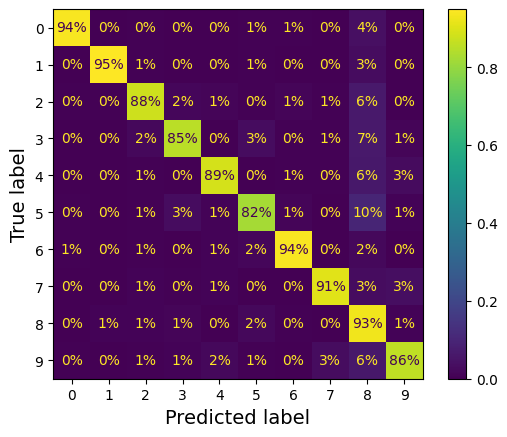

In [67]:
plt.rc("font", size=10)
ConfusionMatrixDisplay.from_predictions(
    y_train, y_train_pred, normalize="true", values_format=".0%"
)
plt.show()


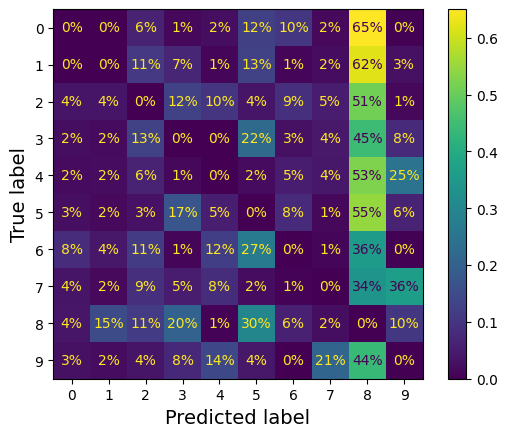

In [68]:
plt.rc("font", size=10)
sample_weight = y_train_pred != y_train
ConfusionMatrixDisplay.from_predictions(
    y_train,
    y_train_pred,
    sample_weight=sample_weight,
    normalize="true",
    values_format=".0%",
)
plt.show()


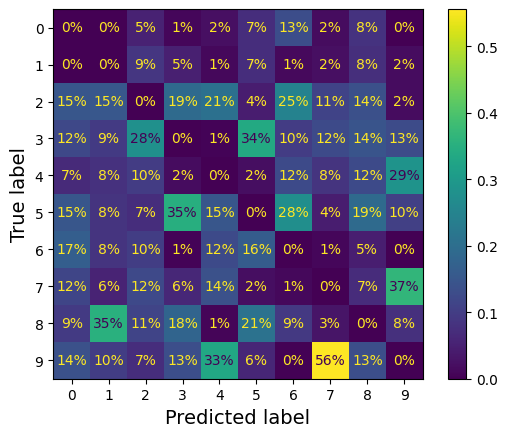

In [69]:
plt.rc("font", size=10)
sample_weight = y_train_pred != y_train
ConfusionMatrixDisplay.from_predictions(
    y_train,
    y_train_pred,
    sample_weight=sample_weight,
    normalize="pred",
    values_format=".0%",
)
plt.show()


In [70]:
cl_a, cl_b = "3", "5"
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


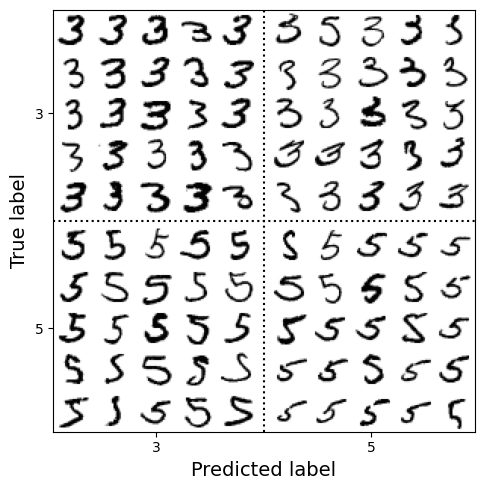

In [71]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [
    (X_ba, (0, 0)),
    (X_bb, (1, 0)),
    (X_aa, (0, 1)),
    (X_ab, (1, 1)),
]:
    for idx, image_data in enumerate(images[: size * size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(
            image_data.reshape(28, 28),
            cmap="binary",
            extent=(x, x + 1, y, y + 1),
        )

plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()


# Multilabel Classification

In [72]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = y_train >= "7"
y_train_odd = y_train.astype("int8") % 2 == 1
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [73]:
knn_clf.predict([some_digit])


array([[False,  True]])

In [74]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")


0.9764102655606048

In [75]:
# extra code – shows that we get a negligible performance improvement when we
#              set average="weighted" because the classes are already pretty
#              well balanced.
f1_score(y_multilabel, y_train_knn_pred, average="weighted")


0.9778357403921755

In [76]:
from sklearn.multioutput import ClassifierChain

chaind_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chaind_clf.fit(X_train[:2000], y_multilabel[:2000])


,estimator,SVC()
,order,None
,cv,3
,chain_method,'predict'
,random_state,42
,verbose,False
,base_estimator,'deprecated'
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [77]:
chaind_clf.predict([some_digit])


array([[0., 1.]])

# Multioutput Classification

In [78]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test


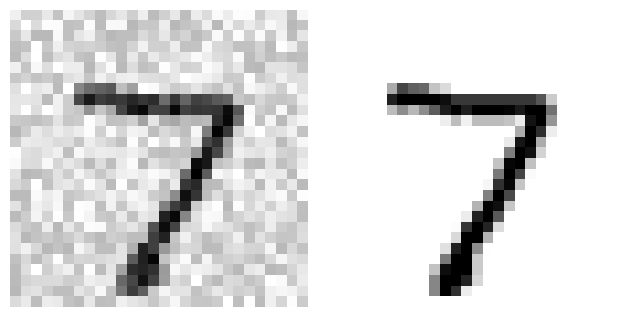

In [79]:
plt.subplot(121)
plot_digit(X_test_mod[0])
plt.subplot(122)
plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()


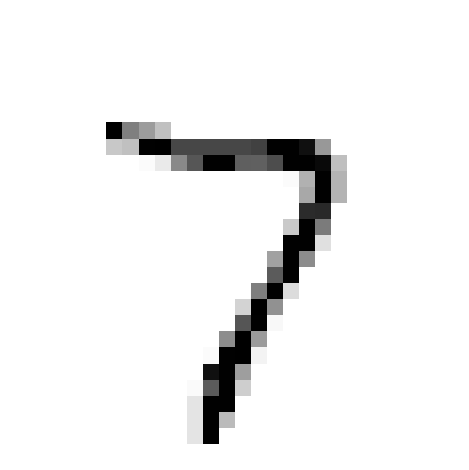

In [80]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_out")
plt.show()


# Exercise Solutions

## 1. An MNIST Classifier With Over 97% Accuracy

Exercise: _Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the `KNeighborsClassifier` works quite well for this task; you just need to find good hyperparameter values (try a grid search on the `weights` and `n_neighbors` hyperparameters)._

In [81]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy


0.9688

In [82]:
from sklearn.model_selection import GridSearchCV

params_grid = [
    {
        "n_neighbors": [3, 4, 5, 6],
        "weights": ["uniform", "distance"],
    }
]

grid_search = GridSearchCV(knn_clf, params_grid, cv=5)
grid_search.fit(X_train[:10000], y_train[:10000])


,estimator,KNeighborsClassifier()
,param_grid,"[{'n_neighbors': [3, 4, ...], 'weights': ['uniform', 'distance']}]"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,4


In [83]:
grid_search.best_params_


{'n_neighbors': 4, 'weights': 'distance'}

In [84]:
grid_search.best_score_


np.float64(0.9441999999999998)

In [85]:
grid_search.best_estimator_.fit(X_train, y_train)
tunned_accuracy = grid_search.score(X_test, y_test)
tunned_accuracy


0.9714

## 2. Data Augmentation

Exercise: _Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. You can use the `shift()` function from the `scipy.ndimage` module. For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called _data augmentation_ or _training set expansion_._

In [86]:
from scipy.ndimage import shift


In [87]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])


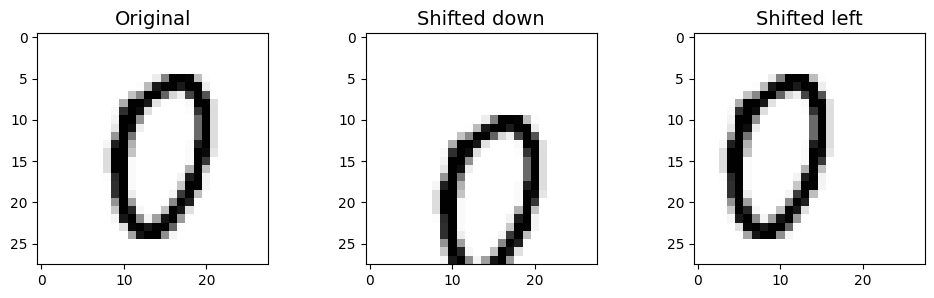

In [88]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(
    shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys"
)
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(
    shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys"
)
plt.show()


In [89]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)


In [90]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]


In [91]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)


In [92]:
knn_clf.fit(X_train_augmented, y_train_augmented)


,n_neighbors,4
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [93]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy


0.9763

In [94]:
error_rate_change = (1 - augmented_accuracy) / (1 - tunned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")


error_rate_change = -17%


## 3. Tackle the Titanic dataset

Exercise: _Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic). Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files: _train.csv_ and _test.csv_ which you can load using `pandas.read_csv()`. The goal is to train a classifier that can predict the `Survived` column based on the other columns._

In [95]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request


def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")

    return [
        pd.read_csv(Path("datasets/titanic") / filename)
        for filename in ("train.csv", "test.csv")
    ]


In [96]:
train_data, test_data = load_titanic_data()


In [97]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")


In [98]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [99]:
train_data[train_data["Sex"] == "female"]["Age"].median()


np.float64(27.0)

In [100]:
train_data.describe()


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [101]:
train_data["Survived"].value_counts()


Survived
0    549
1    342
Name: count, dtype: int64

In [102]:
train_data["Pclass"].value_counts()


Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [103]:
train_data["Sex"].value_counts()


Sex
male      577
female    314
Name: count, dtype: int64

In [104]:
train_data["Embarked"].value_counts()


Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [105]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline(
    [("impute", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)


In [106]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

cat_pipeline = Pipeline(
    [
        ("ordinal_encoder", OrdinalEncoder()),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ]
)


In [107]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer(
    [("num", num_pipeline, num_attribs), ("cat", cat_pipeline, cat_attribs)]
)


In [108]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train


array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]], shape=(891, 12))

In [109]:
y_train = train_data["Survived"]


In [110]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [111]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)


In [112]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()


np.float64(0.8137578027465668)

In [113]:
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()


np.float64(0.8249313358302123)

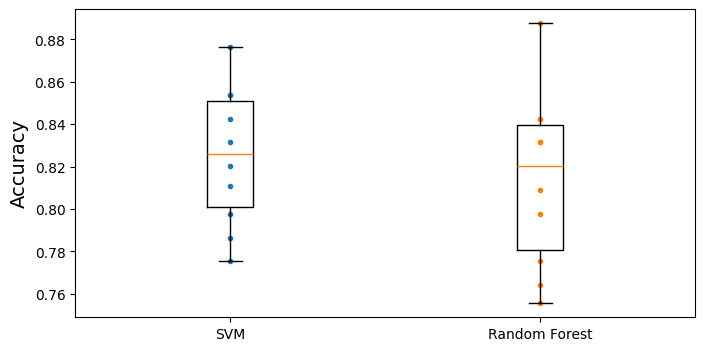

In [114]:
plt.figure(figsize=(8, 4))
plt.plot([1] * 10, svm_scores, ".")
plt.plot([2] * 10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], tick_labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()


In [115]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(["AgeBucket"]).mean()


,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [116]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(
    ["RelativesOnboard"]
).mean()


,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [117]:
X_train = preprocess_pipeline.fit_transform(train_data)
y_train = train_data["Survived"]

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()


np.float64(0.8249313358302123)

In [118]:
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=10)
knn_scores.mean()


np.float64(0.8058676654182273)

In [119]:
params_grid = [
    {
        "n_neighbors": [3, 4, 5, 6],
        "weights": ["uniform", "distance"],
    }
]

grid_search = GridSearchCV(knn_clf, params_grid, cv=10)
grid_search.fit(X_train[:10000], y_train[:10000])


,estimator,KNeighborsClassifier()
,param_grid,"[{'n_neighbors': [3, 4, ...], 'weights': ['uniform', 'distance']}]"
,scoring,None
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,6


In [120]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=10)
knn_scores.mean()


np.float64(0.8092259675405742)

## 4. Spam classifier

Exercise: _Build a spam classifier (a more challenging exercise):_

* _Download examples of spam and ham from [Apache SpamAssassin's public datasets](https://homl.info/spamassassin)._
* _Unzip the datasets and familiarize yourself with the data format._
* _Split the datasets into a training set and a test set._
* _Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, "Hello," "how," "are," "you," then the email "Hello you Hello Hello you" would be converted into a vector [1, 0, 0, 1] (meaning [“Hello" is present, "how" is absent, "are" is absent, "you" is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word._

_You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with "URL," replace all numbers with "NUMBER," or even perform _stemming_ (i.e., trim off word endings; there are Python libraries available to do this)._

_Finally, try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision._

In [122]:
import tarfile


def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (
        ("easy_ham", "ham", ham_url),
        ("spam", "spam", spam_url),
    ):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()

    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]


In [ ]:
ham_dir, spam_dir = fetch_spam_data()


In [124]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]


In [ ]:
len(ham_filenames)


2500

In [ ]:
len(spam_filenames)


500

In [127]:
import email
import email.policy


def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)


In [128]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]


In [129]:
print(ham_emails[1].get_content().strip())


Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [130]:
print(spam_emails[6].get_content().strip())


Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


In [131]:
def get_email_structure(email):
    if isinstance(email, str):
        return email

    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join(
            [get_email_structure(sub_email) for sub_email in payload]
        )
        return f"multipart({multipart})"
    else:
        return email.get_content_type()


In [132]:
from collections import Counter


def structure_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1

    return structures


In [ ]:
structure_counter(ham_emails).most_common()


[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [ ]:
structure_counter(spam_emails).most_common()


[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [135]:
for header, value in spam_emails[0].items():
    print(header, ":", value)


Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [ ]:
spam_emails[0]["Subject"]


'Life Insurance - Why Pay More?'

In [140]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [141]:
import re
from html import unescape


def html_to_plain_text(html):
    text = re.sub("<head.*?>.*?</head>", "", html, flags=re.M | re.S | re.I)
    text = re.sub("<a\s.*?>", "HYPERLINK", text, flags=re.M | re.S | re.I)
    text = re.sub("<.*?>", "", text, flags=re.M | re.S)
    text = re.sub(r"(\s*\n)+", "\n", text, flags=re.M | re.S)

    return unescape(text)


In [142]:
html_spam_emails = [
    email
    for email in X_train[y_train == 1]
    if get_email_structure(email) == "text/html"
]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")


<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [143]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")



OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [144]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except:  # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)


In [145]:
print(email_to_text(sample_html_spam)[:100], "...")



OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


In [146]:
import nltk

stemmer = nltk.PorterStemmer()
for word in (
    "Computations",
    "Computation",
    "Computing",
    "Computed",
    "Compute",
    "Compulsive",
):
    print(word, "=>", stemmer.stem(word))


Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [147]:
%pip install -q -U urlextract


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [148]:
import urlextract

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))


['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


In [149]:
from sklearn.base import BaseEstimator, TransformerMixin


class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        strip_headers=True,
        lower_case=True,
        remove_punctuation=True,
        replace_urls=True,
        replace_numbers=True,
        stemming=True,
    ):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, "URL")
            if self.replace_numbers:
                text = re.sub(r"\d+(?:\.\d*)?(?:[eE][+-]?\d+)?", "NUMBER", text)
            if self.remove_punctuation:
                text = re.sub(r"\W+", " ", text, flags=re.M)

            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)

        return np.array(X_transformed)


In [150]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts


array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

In [151]:
from scipy.sparse import csr_matrix


class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size

    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[: self.vocabulary_size]
        self.vocabulary_ = {
            word: index + 1 for index, (word, count) in enumerate(most_common)
        }

        return self

    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)

        return csr_matrix(
            (data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1)
        )


In [152]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 20 stored elements and shape (3, 11)>

In [ ]:
X_few_vectors.toarray()


array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]])

In [ ]:
vocab_transformer.vocabulary_


{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

In [155]:
preprocess_pipeline = Pipeline(
    [
        ("email_to_wordcount", EmailToWordCounterTransformer()),
        ("wordcount_to_vector", WordCounterToVectorTransformer()),
    ]
)

X_train_transformed = preprocess_pipeline.fit_transform(X_train)


In [156]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()


np.float64(0.9845833333333333)

In [ ]:
X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")


Precision: 94.90%
Recall: 97.89%
